<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/colaborative%20filter/FINal_movie-recommendation-system-collaborative-filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/jaime44/movie-recommendation-system-collaborative-filter/edit

In [1]:
import os
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/colaborative filter'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

El código se está ejecutando en Google Colab.
Mounted at /content/drive
Contenido de la carpeta en Google Drive:
['datasets', 'CF_The_age_of_recommeder_System_Original.ipynb', 'cf-based-recsys-by-low-rank-matrix-factorization_Original.ipynb', 'recommendation-systems-tutorial_Original.ipynb', 'recommender-systems-in-python_Original.ipynb', 'netflix-movie-recommendation_Original.ipynb', 'movie-recommender-systems_Original.ipynb', 'movie-recommendation-with-collaborative-filtering_Original.ipynb', 'recommender-systems-in-python-101_Original.ipynb', 'movie-recommendation-with-collaborative-filtering.ipynb', 'movie-recommender-systems.ipynb', 'recommender-systems-in-python.ipynb', 'CF_The_age_of_recommeder_System.ipynb', 'movie-recommendation-system-collaborative-filter_Original.ipynb', 'cf-based-recsys-by-low-rank-matrix-factorization.ipynb', 'movie-recommendation-system-collaborative-filter.ipynb', 'Movie Lens Collaborative Filtering_Original.ipynb', 'collaborative-filtering-nn_Original.i

# **Collaborative Filtering**

<small>Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

There are many ways to decide which users are similar and combine their choices to create a list of recommendations</small>

El filtrado colaborativo es una técnica que puede filtrar elementos que podrían gustar a un usuario basándose en las reacciones de usuarios similares.

Funciona buscando en un grupo grande de personas y encontrando un conjunto más pequeño de usuarios con gustos similares a los de un usuario concreto. Observa los artículos que les gustan y los combina para crear una lista clasificada de sugerencias.

Hay muchas formas de decidir qué usuarios son similares y combinar sus elecciones para crear una lista de recomendaciones

![colaborative filtering.png](attachment:5c14f24e-aec1-4538-9e9e-c3361ecad485.png)

En nuestro proyecto utilizamos el método de correlación

# 1.Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. load two datasets

In [3]:
rating = pd.read_csv(path_absolute+"Dataset.csv")

In [4]:
rating.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [5]:
movie = pd.read_csv(path_absolute+"Movie_Id_Titles.csv")

In [6]:
movie.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


# 3. Merge both the datasets based on Itemid

In [7]:
df = pd.merge(movie,rating, on='item_id')

In [8]:
df.head()

,item_id,title,user_id,rating,timestamp
0,1,Toy Story (1995),308,4,887736532
1,1,Toy Story (1995),287,5,875334088
2,1,Toy Story (1995),148,4,877019411
3,1,Toy Story (1995),280,4,891700426
4,1,Toy Story (1995),66,3,883601324


In [9]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
# df_ratings_merge = df_ratings_merge.sample(n=50000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()

df = df_ratings_merge.copy()

(8949372, 13)
(8949372, 11)


In [10]:
df.head()

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
0,3,260,1439472239,classic,1439472355,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
1,3,260,1439472239,sci-fi,1439472256,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
2,264,260,1543390081,aliens,1543390134,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
3,264,260,1543390081,oldie but goodie,1543390130,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
4,264,260,1543390081,scifi cult,1543390105,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0


# 4.EDA

In [11]:
df.shape

(8949372, 11)

In [12]:
df['rating'].value_counts()

4.0    2067570
5.0    1901803
4.5    1518686
3.5    1349780
3.0     895858
2.5     437718
2.0     335858
1.5     167000
1.0     148428
0.5     126671
Name: rating, dtype: int64

In [13]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Take Care of My Cat (Goyangileul butaghae) (2001)                      5.0
Celine and Julie Go Boating (Celine et Julie vont en bateau) (1974)    5.0
Nil By Mouth (1997)                                                    5.0
Our Lady of the Assassins (Virgen de los sicarios, La) (2000)          5.0
Haiku Tunnel (2001)                                                    5.0
Winnie the Pooh and the Day of Concern (1972)                          5.0
Benny Goodman Story, The (1955)                                        5.0
Duets (2000)                                                           5.0
Dance of Reality, The (Danza de la realidad, La) (2013)                5.0
Louis C.K.: One Night Stand (2005)                                     5.0
Name: rating, dtype: float64

# 5.Visualisation

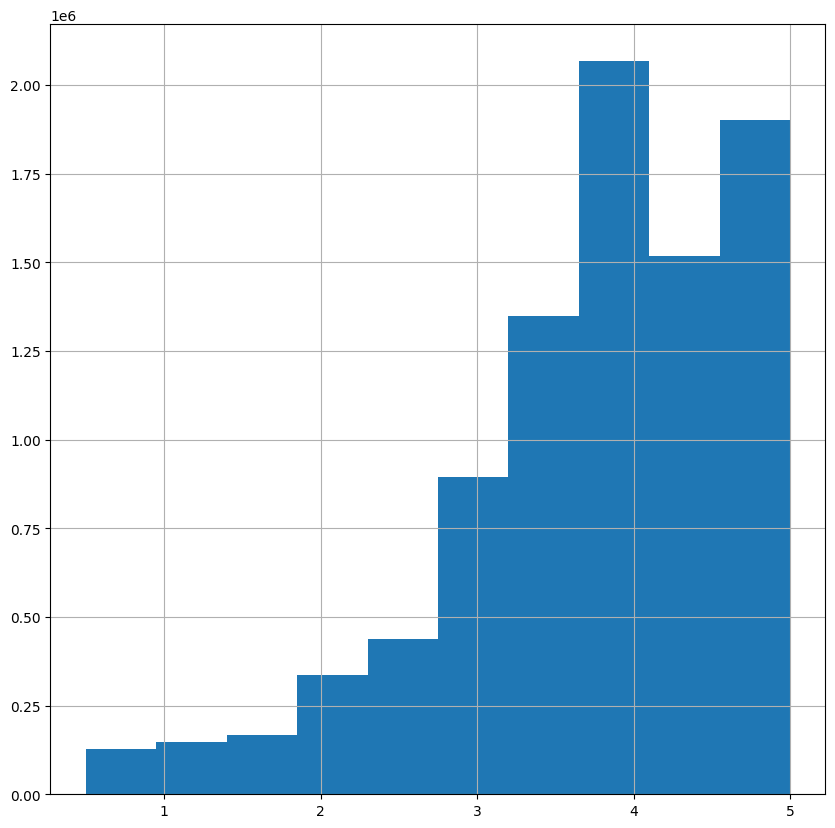

In [14]:
df['rating'].hist(figsize= (10,10))
plt.show()

<ipython-input-15-d7b2f3978c4e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tc = df.corr()


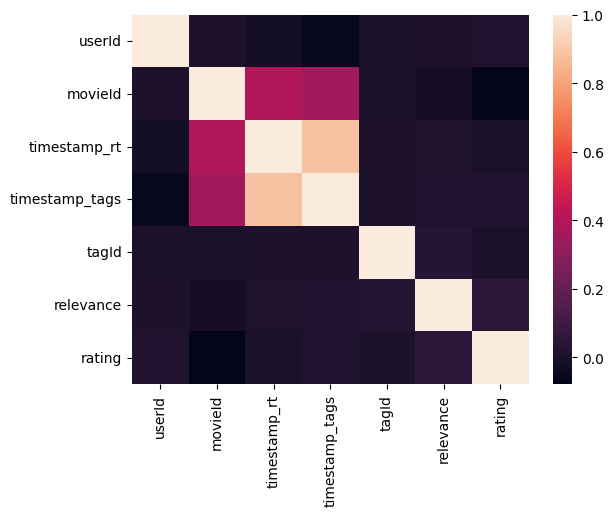

In [15]:
tc = df.corr()
sns.heatmap(tc)
plt.show()


# 6.create a ratings dataframe with average rating and number of ratings

In [16]:
ratings =pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),3.800000
'Round Midnight (1986),4.500000
'Salem's Lot (2004),5.000000
"'burbs, The (1989)",3.336735
'night Mother (1986),4.000000


In [17]:
ratings['rating_numbers'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [18]:
ratings.head()

,rating,rating_numbers
title,,
'71 (2014),3.800000,220
'Round Midnight (1986),4.500000,12
'Salem's Lot (2004),5.000000,18
"'burbs, The (1989)",3.336735,392
'night Mother (1986),4.000000,48


# 7. Create Pivot table

In [19]:
df.head()

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
0,3,260,1439472239,classic,1439472355,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
1,3,260,1439472239,sci-fi,1439472256,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
2,264,260,1543390081,aliens,1543390134,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
3,264,260,1543390081,oldie but goodie,1543390130,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
4,264,260,1543390081,scifi cult,1543390105,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0


## Esta matriz (movieRate) es una representación de las calificaciones dadas por los usuarios a las películas. Las filas representan usuarios, las columnas representan títulos de películas y los valores son las calificaciones. Las celdas que no tienen calificación se llenan con ceros.

In [20]:
movieRate = df.pivot_table(index='userId', columns='title', values='rating')
movieRate.fillna(0, inplace=True)

In [21]:
movieRate.head()

title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),(Untitled) (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),...,[REC]³ 3 Génesis (2012),eXistenZ (1999),iBoy (2017),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: Return of Xander Cage (2017),xXx: State of the Union (2005),¡Three Amigos! (1986),À nos amours (1983),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 8.Recommendation system

Calcular la correlación entre la película de entrada (la película para la cual queremos hacer recomendaciones) y todas las demás películas en la matriz movieRate

Calcula la **correlación de Pearson** entre las calificaciones de cada película en movieRate y las calificaciones del usuario especificado por user_rating.
La función **corrwith** compara las calificaciones de la película de entrada con las calificaciones de cada otra película en términos de su similitud. Esto puede ayudar a identificar películas que tienen calificaciones similares por parte de los usuarios.


La variable min_rating_count en el código que proporcionaste es un umbral utilizado para filtrar las películas recomendadas basándose en el número mínimo de calificaciones que deben tener. Veamos cómo se utiliza en la función

In [22]:
def recommendMovies(name , min_rating_count = 50):
    user_rating = movieRate[name]
    similar_movies = movieRate.corrwith(user_rating)
    corr_movies = pd.DataFrame(similar_movies, columns=['Correlation'])
    corr_movies.dropna(inplace=True)
    #corr_movies.sort_values('Correlation', ascending=False).head(10)
    # Joining the rating_number list so that we can filter basis minimum count of ratings to be considered
    # for recommending a movie
    corr_movies = corr_movies.join(ratings['rating_numbers'], how='left', lsuffix='_left', rsuffix='_right')

    final = corr_movies[corr_movies['rating_numbers']>min_rating_count].sort_values('Correlation', ascending=False)
    return final

In [23]:
user_rating = movieRate["Harry Potter and the Goblet of Fire (2005)"]
similar_movies = movieRate.corrwith(user_rating)
corr_movies = pd.DataFrame(similar_movies, columns=['Correlation'])
corr_movies.dropna(inplace=True)

In [24]:
recommendations = recommendMovies('Harry Potter and the Goblet of Fire (2005)')
recommendations.head(n=10)

,Correlation,rating_numbers
title,,
Harry Potter and the Goblet of Fire (2005),1.000000,5654
Harry Potter and the Prisoner of Azkaban (2004),0.558406,4610
Harry Potter and the Chamber of Secrets (2002),0.557424,3059
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.537162,6984
Harry Potter and the Order of the Phoenix (2007),0.517574,2192
Harry Potter and the Half-Blood Prince (2009),0.440126,3624
Harry Potter and the Deathly Hallows: Part 1 (2010),0.417556,6432
Harry Potter and the Deathly Hallows: Part 2 (2011),0.314454,3798
"Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)",0.283126,4763


# Conclusion

1. we build a collaborative recommendation system to recommend movies.
2. memory based approch is used.

**Enfoques colaborativos basados en la memoria**

Las principales características de usuario-usuario e ítem-ítem se aproximan a que utilizan solo información de la matriz de interacción usuario-ítem y no asumen ningún modelo para producir nuevas recomendaciones.


-------------------------------------------

## Similitud con Pearson
**.corr()**

**df.corr(method='pearson'):**

Esta función calcula la correlación entre las columnas de un DataFrame.
method='pearson' indica que se está utilizando el coeficiente de correlación de Pearson, que mide la correlación lineal entre dos variables continuas. Toma valores entre -1 y 1, donde 1 significa una correlación positiva perfecta, -1 significa una correlación negativa perfecta, y 0 significa ausencia de correlación lineal.
En el contexto del código que proporcionaste, se utiliza para calcular la correlación entre todas las columnas del DataFrame df.

In [25]:
ratings = df.copy()

In [26]:
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings.head()
print("Before: ",userRatings.shape)
userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
#userRatings.fillna(0, inplace=True)
print("After: ",userRatings.shape)

Before:  (12918, 12104)
After:  (12918, 3962)


In [27]:
corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),11:14 (2003),12 (2007),...,Zodiac (2007),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007),[REC]² (2009),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,0.009411,0.051558,0.049914,0.031373,-0.001340,0.032196,0.101357,0.034663,0.061485,...,0.070433,0.232042,0.096861,0.104652,0.098560,0.114497,0.123120,0.028868,0.052235,0.242634
(500) Days of Summer (2009),0.009411,1.000000,0.071827,0.066188,0.159382,0.002250,0.040375,0.050690,0.072657,0.013820,...,0.058739,-0.003832,0.095285,0.045800,0.061144,0.078611,0.021730,0.026065,0.006847,0.006586
10 Cloverfield Lane (2016),0.051558,0.071827,1.000000,0.018365,0.088895,0.051565,0.037949,0.056280,0.056452,0.023197,...,0.133159,0.016469,0.068990,0.055435,0.090550,0.049200,0.029795,0.064918,0.031941,0.058193
10 Items or Less (2006),0.049914,0.066188,0.018365,1.000000,0.030563,-0.001137,0.033167,0.027710,0.035744,0.063130,...,0.013975,-0.000910,0.067382,0.018620,-0.002251,-0.001828,-0.000817,-0.002050,0.043755,0.043231
10 Things I Hate About You (1999),0.031373,0.159382,0.088895,0.030563,1.000000,0.057888,0.095330,0.100500,0.079789,0.020529,...,0.064310,-0.002545,0.118463,0.101288,0.101140,0.098648,0.036026,0.046968,0.068570,0.066104


In [28]:
def get_similar(movie_name,rating):
    similar_ratings = corrMatrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [29]:
romantic_lover = [("(500) Days of Summer (2009)",5),("Alice in Wonderland (2010)",3),
                  ("Aliens (1986)",1),("2001: A Space Odyssey (1968)",2)]
similar_movies = pd.DataFrame()
for movie,rating in romantic_lover:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(14)
similar_movies.sum().sort_values(ascending=False).head(14)

<ipython-input-29-4635b18eae04>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
<ipython-input-29-4635b18eae04>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
<ipython-input-29-4635b18eae04>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
<ipython-input-29-4635b18eae04>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,ratin

title
(500) Days of Summer (2009)                  2.504148
Alice in Wonderland (2010)                   0.628119
Definitely, Maybe (2008)                     0.478287
Love and Other Drugs (2010)                  0.445546
Perks of Being a Wallflower, The (2012)      0.431016
Nick and Norah's Infinite Playlist (2008)    0.409706
Up in the Air (2009)                         0.409039
Into the Wild (2007)                         0.399991
Crazy, Stupid, Love. (2011)                  0.390995
Yes Man (2008)                               0.383878
He's Just Not That Into You (2009)           0.371512
Holiday, The (2006)                          0.365468
27 Dresses (2008)                            0.365398
Midnight in Paris (2011)                     0.362224
dtype: float64

In [30]:
# action_lover = [("Amazing Spider-Man, The (2012)",5),("Mission: Impossible III (2006)",4),
#                 ("Toy Story 3 (2010)",2),("2 Fast 2 Furious (Fast and the Furious 2, The) (2003)",4)]
# similar_movies = pd.DataFrame()
# for movie,rating in action_lover:
#     similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

# similar_movies.head(10)
# similar_movies.sum().sort_values(ascending=False).head(14)

In [31]:
movies = [("Harry Potter and the Goblet of Fire (2005)",4)]
similar_movies = pd.DataFrame()
for movie,rating in movies:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(10)
similar_movies.sum().sort_values(ascending=False).head(14)

<ipython-input-31-380c8c8616d2>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)


title
Harry Potter and the Goblet of Fire (2005)                                                        1.500000
Harry Potter and the Prisoner of Azkaban (2004)                                                   0.837609
Harry Potter and the Chamber of Secrets (2002)                                                    0.836137
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)    0.805744
Harry Potter and the Order of the Phoenix (2007)                                                  0.776362
Harry Potter and the Half-Blood Prince (2009)                                                     0.660188
Harry Potter and the Deathly Hallows: Part 1 (2010)                                               0.626334
Harry Potter and the Deathly Hallows: Part 2 (2011)                                               0.471681
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)                            0.424689
Pirates of the Caribbean: At Wo

-------------------------------------------

### **Single Value Decomposition** SVD

In [32]:
if IN_COLAB:
  !pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162669 sha256=f3b8b4e4ba5f879f9ab1e113b12b8a00896c970044029ab008215ab594ec8fdc
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [33]:
ratings = df.copy()

In [34]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings.head()

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
0,3,260,1439472239,classic,1439472355,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
1,3,260,1439472239,sci-fi,1439472256,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.0
2,264,260,1543390081,aliens,1543390134,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
3,264,260,1543390081,oldie but goodie,1543390130,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0
4,264,260,1543390081,scifi cult,1543390105,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,3.0


Este conjunto de datos contiene información sobre las calificaciones de películas proporcionadas por usuarios.

In [35]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

Se utiliza el método build_full_trainset() para construir un conjunto de entrenamiento completo con todas las calificaciones del conjunto de datos.

In [36]:
from surprise.model_selection import train_test_split

# Construir el conjunto de entrenamiento completo
trainset = data.build_full_trainset()
trainset

**SVD (Descomposición de Valor Singular)**

Se crea una instancia del modelo SVD. Este modelo se utiliza para realizar el filtrado colaborativo basado en la descomposición de valor singular.

Se utiliza el método cross_validate para evaluar el rendimiento del modelo mediante validación cruzada. Se mide el error cuadrático medio (RMSE) y el error absoluto medio (MAE) en cinco divisiones del conjunto de datos.

In [37]:
svd = SVD()

# Evaluación del modelo usando cross_validate
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2290  0.2306  0.2309  0.2307  0.2315  0.2305  0.0008  
MAE (testset)     0.1430  0.1435  0.1440  0.1436  0.1441  0.1437  0.0004  
Fit time          162.56  170.38  171.15  169.64  170.68  168.88  3.20    
Test time         46.85   56.19   37.17   37.86   47.98   45.21   7.06    


{'test_rmse': array([0.22895533, 0.23062876, 0.23086907, 0.23069564, 0.2315126 ]),
 'test_mae': array([0.14298699, 0.14348863, 0.14403082, 0.14364022, 0.14411894]),
 'fit_time': (162.55725646018982,
  170.383394241333,
  171.14500522613525,
  169.64331722259521,
  170.67730236053467),
 'test_time': (46.848288774490356,
  56.18998169898987,
  37.17435121536255,
  37.86212706565857,
  47.98072409629822)}

Se entrena el modelo SVD utilizando el conjunto de entrenamiento completo.

In [38]:
# trainset = data.build_full_trainset()
svd.fit(trainset)

In [39]:
ratings[ratings['userId'] == 29801]

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
1049,29801,260,1437328071,classic adventure,1437328091,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.5
1050,29801,260,1437328071,fairy tale,1437328116,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.5
1051,29801,260,1437328071,fantasy action,1437328292,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.5
1052,29801,260,1437328071,good vs evil,1437328220,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.5
1053,29801,260,1437328071,space adventure,1437328162,art,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,75,0.26025,4.5
...,...,...,...,...,...,...,...,...,...,...,...
8947771,29801,80126,1444952858,complicated relationships,1444952919,heroine in tight suit,"American, The (2010)",Drama|Thriller,501,0.01075,5.0
8947772,29801,80126,1444952858,George Clooney,1444952899,heroine in tight suit,"American, The (2010)",Drama|Thriller,501,0.01075,5.0
8947773,29801,80126,1444952858,slow,1444952904,heroine in tight suit,"American, The (2010)",Drama|Thriller,501,0.01075,5.0
8947774,29801,80126,1444952858,suspense,1444952895,heroine in tight suit,"American, The (2010)",Drama|Thriller,501,0.01075,5.0


Dado el ID de la peícula, 215, el id del usuario 29801 y el valor de calificación real que se utilizará para evaluar la predicción. Si no se proporciona, la función devolverá solo la predicción estimada. Intenta predecir el valor.

In [40]:
svd.predict(29801, 215, 5)

Prediction(uid=29801, iid=215, r_ui=5, est=4.592891215039451, details={'was_impossible': False})

In [41]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado 'df' con el formato proporcionado
# y otro DataFrame llamado 'movies' que contiene información sobre las películas

usuario_id = 29801

# Filtrar el DataFrame para obtener las películas vistas por el usuario
peliculas_vistas_usuario = df[df['userId'] == usuario_id][['movieId', 'title']].drop_duplicates()

# Mostrar el DataFrame con las películas vistas por el usuario
print(peliculas_vistas_usuario)

         movieId                                      title
1049         260  Star Wars: Episode IV - A New Hope (1977)
21003      35957                             Red Eye (2005)
31648      42011              Fun with Dick and Jane (2005)
33922       6436                     This Boy's Life (1993)
56818       7031                     Real McCoy, The (1993)
...          ...                                        ...
2095553      173                         Judge Dredd (1995)
2385343   113573        Sin City: A Dame to Kill For (2014)
2585357   111622                         Begin Again (2013)
2650224     6902                       Interstate 60 (2002)
4187560    88163                Crazy, Stupid, Love. (2011)

[96 rows x 2 columns]


In [42]:
import pandas as pd

# Obtener el movieId de "Harry Potter and the Goblet of Fire (2005)"
movie_id_harry_potter = df.loc[df['title'] == 'Harry Potter and the Goblet of Fire (2005)', 'movieId'].values[0]

# Obtener predicciones para todas las películas
all_movie_ids = df['movieId'].unique()
predictions = [svd.predict(29801, movie_id) for movie_id in all_movie_ids]

# Crear un DataFrame con las predicciones
recommendations_df = pd.DataFrame({
    'movieId': [prediction.iid for prediction in predictions],
    'title': [df.loc[df['movieId'] == prediction.iid, 'title'].values[0] for prediction in predictions],
    'estimated_rating': [prediction.est for prediction in predictions]
})

# Ordenar el DataFrame por valor estimado en orden descendente
recommendations_df = recommendations_df.sort_values(by='estimated_rating', ascending=False)

# Imprimir el DataFrame
recommendations_df.head(10)


,movieId,title,estimated_rating
7982,1945,On the Waterfront (1954),5.0
878,5142,"Firemen's Ball, The (Horí, má panenko) (1967)",5.0
8638,8724,"Leopard, The (Gattopardo, Il) (1963)",5.0
467,6,Heat (1995),5.0
10822,8740,"Lower Depths, The (Donzoko) (1957)",5.0
5916,953,It's a Wonderful Life (1946),5.0
7378,65188,Dear Zachary: A Letter to a Son About His Fath...,5.0
10793,55167,Tekkonkinkreet (Tekkon kinkurîto) (2006),5.0
4631,1968,"Breakfast Club, The (1985)",5.0
5364,7234,"Strada, La (1954)",5.0


----------------------------

## Sistema de Recomendación de Películas basado en Vecinos Más Cercanos con Similitud de Coseno

En este código, se implementa un sistema de recomendación de películas utilizando el método de vecinos más cercanos (k-nearest neighbors) y la similitud de coseno. El proceso comienza con la creación de una matriz de valoraciones que representa las calificaciones de los usuarios para cada película. Se eliminan las filas duplicadas y se realiza un análisis del número de votos por película y usuario.

Posteriormente, se ajusta un modelo de vecinos más cercanos utilizando la similitud de coseno como medida de distancia. La matriz de valoraciones se convierte en una matriz esparsa para mejorar la eficiencia. Se define una función que toma el nombre de una película y devuelve recomendaciones de películas similares, utilizando el modelo KNN previamente entrenado.

Finalmente, se ilustra el uso de la función proporcionando recomendaciones para la película "Matrix, The (1999)". Este sistema proporciona a los usuarios sugerencias de películas basadas en la similitud de sus preferencias con las de otros usuarios.

In [43]:
df_data = df.copy()

In [44]:
# Eliminar filas duplicadas basadas en las columnas 'userId' y 'movieId'
ratings = ratings.drop_duplicates(subset=['userId', 'movieId'])

In [45]:
data = pd.pivot(index = 'movieId',columns = 'userId', data = ratings,values ='rating')
data.head()

userId,3,4,19,20,43,68,87,91,93,95,...,162400,162423,162440,162447,162462,162467,162492,162501,162512,162521
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
movies = df_data[['movieId', 'title', 'genres']]
ratings = df_data[['userId', 'movieId', 'rating', 'timestamp_rt']]

In [47]:
ratings.head()

,userId,movieId,rating,timestamp_rt
0,3,260,4.0,1439472239
1,3,260,4.0,1439472239
2,264,260,3.0,1543390081
3,264,260,3.0,1543390081
4,264,260,3.0,1543390081


In [48]:
movies.head()

,movieId,title,genres
0,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [49]:
numberOf_user_voted_for_movie = pd.DataFrame(ratings.groupby('movieId')['rating'].agg('count'))
numberOf_user_voted_for_movie.reset_index(level = 0,inplace = True)
numberOf_user_voted_for_movie.head()

,movieId,rating
0,1,8064
1,2,2262
2,3,231
3,4,65
4,5,210


In [50]:
data.shape

(12105, 12918)

In [51]:
numberOf_movies_voted_by_user = pd.DataFrame(ratings.groupby('userId')['rating'].agg('count'))
numberOf_movies_voted_by_user.reset_index(level = 0,inplace = True)
numberOf_movies_voted_by_user.head()

,userId,rating
0,3,28
1,4,97
2,19,84
3,20,10
4,43,8


In [52]:
data.fillna(0,inplace = True)
data.head()

userId,3,4,19,20,43,68,87,91,93,95,...,162400,162423,162440,162447,162462,162467,162492,162501,162512,162521
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
numberOf_user_voted_for_movie.describe()

,movieId,rating
count,12105.000000,12105.000000
mean,48374.156795,739.312020
std,56019.078329,2308.418884
min,1.000000,3.000000
25%,4102.000000,56.000000
50%,25855.000000,160.000000
75%,84601.000000,490.000000
max,206499.000000,84546.000000


In [54]:
numberOf_movies_voted_by_user.describe()

,userId,rating
count,12918.000000,12918.000000
mean,81086.895340,692.783093
std,46818.876612,4142.736011
min,3.000000,3.000000
25%,40541.750000,26.000000
50%,81206.500000,56.000000
75%,121879.000000,235.000000
max,162521.000000,217078.000000


Text(0, 0.5, 'Number Of Users Voted for Movie')

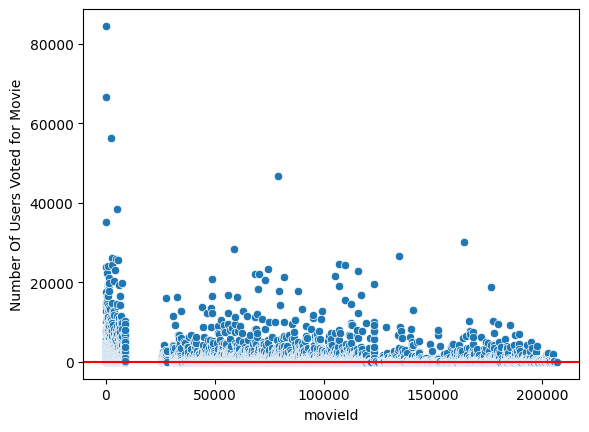

In [55]:
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'movieId', data = numberOf_user_voted_for_movie)
plt.axhline(y=10,color='r')
plt.ylabel('Number Of Users Voted for Movie')

Text(0, 0.5, 'Number Of Movies rated by user')

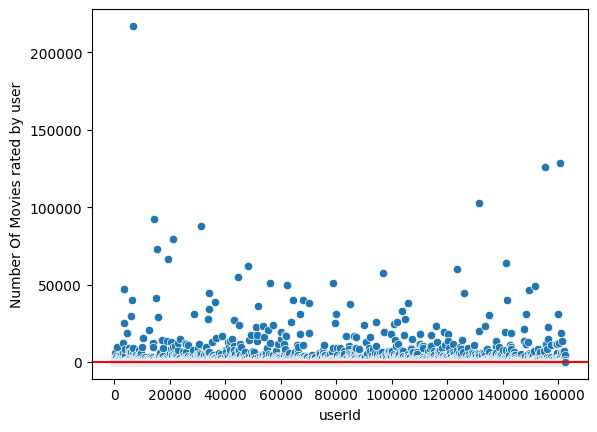

In [56]:
plt.figure()
ax = sns.scatterplot(y = 'rating', x = 'userId', data = numberOf_movies_voted_by_user)
plt.axhline(y=60,color='r')
plt.ylabel('Number Of Movies rated by user')

In [1]:
data_final = data.loc[numberOf_user_voted_for_movie[numberOf_user_voted_for_movie['rating'] > 10]['movieId'],:]
data_final = data_final.loc[:,numberOf_movies_voted_by_user[numberOf_movies_voted_by_user['rating'] > 60]['userId']]
data_final.shape

NameError: name 'data' is not defined

In [ ]:
data_final

Se crea una matriz esparsa a partir de los datos y se ajusta un modelo de vecinos más cercanos (k-NN) utilizando la similitud de coseno como métrica de distancia.

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
csr_data = csr_matrix(data_final.values)
data_final.reset_index(inplace=True)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(csr_data)

In [ ]:
data_final.head()

La función get_movie_recommendation toma el nombre de una película como entrada y devuelve recomendaciones de películas similares utilizando un sistema de recomendación basado en vecinos más cercanos con similitud de coseno. Aquí está una explicación detallada del código:

Parámetros de entrada:

movie_name: Es el nombre de la película para la cual se desea obtener recomendaciones.


Configuración de la función:

n=10: Se establece el número de películas recomendadas que se devolverán.


Filtrado de Películas:

movie_list: Se crea una lista de películas que contienen el nombre proporcionado. Si la lista tiene elementos (longitud diferente de cero), se procede a obtener recomendaciones. De lo contrario, se devuelve un mensaje indicando que no se encontraron películas.

Entrada del Usuario:

El usuario proporciona el nombre de una película de interés, por ejemplo, "Matrix".
Búsqueda de Películas:

Se utiliza la expresión movies[movies['title'].str.contains(movie_name)] para buscar todas las películas que contienen la palabra clave en su título. En este caso, se buscan todas las películas que contienen la palabra "Matrix" en su título.


Validación:

Se verifica si se encontraron películas en la búsqueda. Si len(movie_list) es mayor que cero, significa que al menos una película contiene el nombre proporcionado.


Obtención del movieId:

Se extrae el movieId de la primera película en la lista (movie_list.iloc[0]['movieId']), ya que se asume que el usuario se refiere a esa película.


Obtención del userId correspondiente:

Luego, se busca el índice del userId correspondiente al movieId en el conjunto de datos (data_final[data_final['movieId'] == movie_idx].index[0]). Esto se hace para obtener el usuario que ha visto la película "Matrix".


Recomendación basada en Vecinos Cercanos (knn):

Se utilizan los vecinos más cercanos (knn.kneighbors) para encontrar películas similares a la película "Matrix" según las preferencias del usuario correspondiente.


Formateo de Resultados:

Se crea un DataFrame (df) que contiene las películas recomendadas y sus distancias respecto a la película de interés.


Obtención del Índice de Película:

movie_idx: Se obtiene el identificador único de la película (movieId) desde la lista filtrada de películas. Luego, se encuentra el índice correspondiente en la matriz de valoraciones (data_final) para ese movieId.


Cálculo de Vecinos Más Cercanos:

distances, indices: Se utilizan las funciones de vecinos más cercanos del modelo KNN (kneighbors) para calcular las distancias y los índices de las películas más cercanas a la película de interés. El número de vecinos se establece en n + 1 para incluir la propia película.


Ordenamiento y Recolección de Recomendaciones:

rec_movie_indices: Se ordenan las distancias y se recopilan los índices y distancias de las películas más cercanas, excluyendo la película de interés.
Se itera sobre estos índices y se recopilan los títulos y las distancias de las películas recomendadas.


Construcción del DataFrame de Recomendaciones:

Se crea un DataFrame (df) que contiene dos columnas: "Title" (Título de la película recomendada) y "Distance" (Distancia de similitud). Este DataFrame se establece con el índice en las distancias.

Retorno de Resultados:

Se devuelve el DataFrame con las recomendaciones si se encontraron películas. Si no se encontraron películas, se devuelve un mensaje indicando que no se encontraron películas para la entrada proporcionada.

En resumen, la función utiliza el modelo de vecinos más cercanos para encontrar películas similares a la película proporcionada y devuelve una lista de recomendaciones junto con las distancias de similitud.

In [ ]:
def get_movie_recommendation(movie_name):
    n= 10
    movie_list = movies[movies['title'].str.contains(movie_name, regex=False)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['movieId'] #movieId
        movie_idx = data_final[data_final['movieId'] == movie_idx].index[0] #userId acc to movieId
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze(),distances.squeeze())),key=lambda x: x[1])[1::1]
        recommend = []
        recommend2 = []
        for val in rec_movie_indices:
            movie_idx = data_final.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend.append(movies.iloc[idx]['title'].values[0])
            recommend2.append(val[1])
        df1 = pd.DataFrame(recommend)
        df2 = pd.DataFrame(recommend2)
        df = pd.concat([df1,df2],axis = 'columns')
        df.columns = ['Title','Distance']
        df.set_index('Distance',inplace = True)
        return df
    else:
        return "No movies found. Please check your input"


In [ ]:
# movie_name = 'Welcome to Collinwood (2002)'
# movie_list = movies[movies['title'].str.contains(movie_name, regex=False)]
# movie_idx= movie_list.iloc[0]['movieId']
# movie_idx = data_final[data_final['movieId'] == movie_idx].index[0]

In [ ]:
# n = input()
# get_movie_recommendation(n.title())
get_movie_recommendation('Harry Potter and the Goblet of Fire (2005)')

-------------------------------------

# Recommendation systems tutorial

In [ ]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
# df_ratings_merge = df_ratings_merge.sample(n=500000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()

data = df_ratings_merge.copy()

In [ ]:
data = data.loc[:,["movieId","title","userId","rating"]]
data.head(10)

In [ ]:
# lets make a pivot table in order to make rows are users and columns are movies. And values are rating
pivot_table = data.pivot_table(index = ["userId"],columns = ["title"],values = "rating")

# Esta instrucción es importante porque maneja los valores faltantes en la tabla pivote
# En este caso, los valores faltantes en la tabla pivote podrían representar películas
# que un usuario no ha calificado. Al rellenar esos valores faltantes con ceros, estás
# asumiendo que si un usuario no ha calificado una película, su calificación es esencialmente cero.
# pivot_table.fillna(0, inplace=True)
pivot_table.head(10)

In [ ]:
movie_watched = pivot_table["Harry Potter and the Goblet of Fire (2005)"]
similarity_with_other_movies = pivot_table.corrwith(movie_watched)  # find correlation between "Bad Boys (1995)" and other movies
similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)
similarity_with_other_movies.head()

-------------------------------------------------------------

# Recommender-systems-in-python

In [ ]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
# df_ratings_merge = df_ratings_merge.sample(n=500000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()

movie_data = df_ratings_merge.copy()

In [ ]:
movie_data.groupby('title')['rating'].mean().head()

In [ ]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

In [ ]:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

In [ ]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())

In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [ ]:
ratings_mean_count.head()

In [ ]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

In [ ]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

In [ ]:
plt.figure(figsize=(10,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [ ]:
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')

user_movie_rating.head()

In [ ]:
forrest_gump_ratings = user_movie_rating["Harry Potter and the Goblet of Fire (2005)"]

forrest_gump_ratings.head()

In [ ]:
movies_like_forest_gump = user_movie_rating.corrwith(forrest_gump_ratings)

In [ ]:
corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])
corr_forrest_gump.dropna(inplace=True)
corr_forrest_gump.head()

In [ ]:
corr_forrest_gump.sort_values('Correlation', ascending=False).head(10)

In [ ]:
corr_forrest_gump = corr_forrest_gump.join(ratings_mean_count['rating_counts'])
corr_forrest_gump.head()

In [ ]:
corr_forrest_gump[corr_forrest_gump ['rating_counts']>50].sort_values('Correlation', ascending=False).head()